In [1]:
from TTS.bin.resample import resample_files

In [2]:
PATH = "Worgen/wavs/"
SAMPLE_RATE = 16000
NUM_RESAMPLE_THREADS = 10
resample_files(PATH, SAMPLE_RATE, file_ext="wav", n_jobs=NUM_RESAMPLE_THREADS)

Resampling the audio files...
Found 131 files...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 131/131 [00:01<00:00, 69.49it/s]

Done !


In [2]:
PATH = "VCTK/"
SAMPLE_RATE = 16000
NUM_RESAMPLE_THREADS = 10
resample_files(PATH, SAMPLE_RATE, file_ext="flac", n_jobs=NUM_RESAMPLE_THREADS)

Resampling the audio files...
Found 88328 files...


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 88328/88328 [07:43<00:00, 190.38it/s]

Done !


In [2]:
from pathlib import Path

path_p362 = 'VCTK/wav48_silence_trimmed/p362'
files = Path(path_p362).glob('*.flac')
filenames = [file.stem for file in files]
filenames[:10]

['p362_002_mic1',
 'p362_002_mic2',
 'p362_003_mic1',
 'p362_003_mic2',
 'p362_005_mic1',
 'p362_005_mic2',
 'p362_009_mic1',
 'p362_009_mic2',
 'p362_010_mic1',
 'p362_010_mic2']

In [10]:
import re

clipnames = set(re.fullmatch(r'(.*)_.*', file).group(1) for file in filenames)
list(clipnames)[:10]

['p362_224',
 'p362_397',
 'p362_308',
 'p362_016',
 'p362_119',
 'p362_312',
 'p362_050',
 'p362_153',
 'p362_213',
 'p362_211']

In [13]:
import os

path_p362 = 'VCTK/txt/p362'
files = Path(path_p362).glob('*.txt')
for file in files:
    if file.stem not in clipnames:
        os.remove(file)
        print(f'Deleted {file}')

Deleted VCTK\txt\p362\p362_001.txt
Deleted VCTK\txt\p362\p362_004.txt
Deleted VCTK\txt\p362\p362_006.txt
Deleted VCTK\txt\p362\p362_007.txt
Deleted VCTK\txt\p362\p362_008.txt
Deleted VCTK\txt\p362\p362_013.txt
Deleted VCTK\txt\p362\p362_014.txt
Deleted VCTK\txt\p362\p362_015.txt
Deleted VCTK\txt\p362\p362_018.txt
Deleted VCTK\txt\p362\p362_020.txt
Deleted VCTK\txt\p362\p362_021.txt
Deleted VCTK\txt\p362\p362_023.txt
Deleted VCTK\txt\p362\p362_024.txt
Deleted VCTK\txt\p362\p362_025.txt
Deleted VCTK\txt\p362\p362_026.txt
Deleted VCTK\txt\p362\p362_031.txt
Deleted VCTK\txt\p362\p362_032.txt
Deleted VCTK\txt\p362\p362_033.txt
Deleted VCTK\txt\p362\p362_034.txt
Deleted VCTK\txt\p362\p362_035.txt
Deleted VCTK\txt\p362\p362_036.txt
Deleted VCTK\txt\p362\p362_038.txt
Deleted VCTK\txt\p362\p362_040.txt
Deleted VCTK\txt\p362\p362_042.txt
Deleted VCTK\txt\p362\p362_043.txt
Deleted VCTK\txt\p362\p362_044.txt
Deleted VCTK\txt\p362\p362_045.txt
Deleted VCTK\txt\p362\p362_046.txt
Deleted VCTK\txt\p36

In [1]:
import torchaudio

In [5]:
x, sr = torchaudio.load(r"C:\Users\iambl\GitHub\TTS\recipes\vctk\yourtts\VCTK\wav48_silence_trimmed\p225\p225_001_mic1.flac")
print(x.min(), x.max())

tensor(-0.7020) tensor(0.7907)


In [12]:
from pathlib import Path

path_vctk = 'VCTK/wav48_silence_trimmed'
mins = []
maxs = []
for file in Path(path_vctk).glob('*/*.flac'):
    x, sr = torchaudio.load(str(file))
    mins.append(x.min())
    maxs.append(x.max())

KeyboardInterrupt: 

In [16]:
from tqdm import tqdm
from multiprocess import Pool
import glob
import os

def clip_file(filename):
    import torchaudio
    try:
        x, sr = torchaudio.load(filename)
    except Exception as e:
        return f"ERROR! Failed to load {filename}: {e}", 0, 0
    amin = x.min()
    amax = x.max()
    if amin < -1 or amax > 1:
        x = x.clip(-1,1)
        torchaudio.save(filename, x, sr)
        # Check that it worked
        x, sr = torchaudio.load(filename)
        if (x > 1).sum() + (x < -1).sum() == 0:
            return f"ERROR! Failed to clip {filename}: Min={x.min()}, Max={x.max()}", amin, amax
    return "", amin, amax

def clip_files(input_dir, output_dir=None, file_ext="wav", n_jobs=10):
    if output_dir:
        print("Recursively copying the input folder...")
        copy_tree(input_dir, output_dir)
        input_dir = output_dir

    print("Clipping the audio files...")
    audio_files = glob.glob(os.path.join(input_dir, f"**/*.{file_ext}"), recursive=True)
    print(f"Found {len(audio_files)} files...")
    minmax = []
    with Pool(processes=n_jobs) as p:
        with tqdm(total=len(audio_files)) as pbar:
            for msg, amin, amax in p.imap_unordered(clip_file, audio_files):
                if msg:
                    print(msg)
                minmax.append((amin, amax))
                pbar.update()

    print("Done !")
    return minmax

In [17]:
PATH = "VCTK/"
NUM_RESAMPLE_THREADS = 10
minmax = clip_files(PATH, file_ext="flac", n_jobs=NUM_RESAMPLE_THREADS)

Clipping the audio files...
Found 88328 files...


  0%|                                                                                                    | 48/88328 [00:01<38:19, 38.39it/s]

ERROR! Failed to load VCTK\wav48_silence_trimmed\p225\p225_017_mic1.flac: array is too big; `arr.size * arr.dtype.itemsize` is larger than the maximum possible size.


  0%|▍                                                                                                 | 378/88328 [00:02<03:35, 408.44it/s]

ERROR! Failed to clip VCTK\wav48_silence_trimmed\p225\p225_002_mic1.flac: Min=-0.998504638671875, Max=0.998992919921875


  2%|██▎                                                                                             | 2169/88328 [00:03<00:41, 2052.90it/s]

ERROR! Failed to clip VCTK\wav48_silence_trimmed\p227\p227_304_mic1.flac: Min=-0.991912841796875, Max=0.998992919921875


  7%|██████▍                                                                                         | 5923/88328 [00:04<00:35, 2312.88it/s]

ERROR! Failed to clip VCTK\wav48_silence_trimmed\p232\p232_159_mic2.flac: Min=-0.998992919921875, Max=0.998992919921875


 18%|█████████████████                                                                              | 15850/88328 [00:08<00:31, 2268.29it/s]

ERROR! Failed to clip VCTK\wav48_silence_trimmed\p247\p247_019_mic1.flac: Min=-0.998992919921875, Max=0.998992919921875


 44%|█████████████████████████████████████████▎                                                     | 38446/88328 [00:18<00:21, 2349.24it/s]

ERROR! Failed to clip VCTK\wav48_silence_trimmed\p274\p274_123_mic1.flac: Min=-0.997802734375, Max=0.998992919921875


 55%|████████████████████████████████████████████████████▍                                          | 48758/88328 [00:23<00:21, 1828.06it/s]

ERROR! Failed to clip VCTK\wav48_silence_trimmed\p286\p286_368_mic1.flac: Min=-0.97125244140625, Max=0.998992919921875


 63%|████████████████████████████████████████████████████████████▏                                  | 55983/88328 [00:26<00:13, 2327.73it/s]

ERROR! Failed to clip VCTK\wav48_silence_trimmed\p299\p299_211_mic1.flac: Min=-0.996063232421875, Max=0.998992919921875
ERROR! Failed to clip VCTK\wav48_silence_trimmed\p299\p299_288_mic1.flac: Min=-0.98919677734375, Max=0.998992919921875


 73%|█████████████████████████████████████████████████████████████████████▍                         | 64609/88328 [00:30<00:10, 2301.42it/s]

ERROR! Failed to clip VCTK\wav48_silence_trimmed\p311\p311_241_mic1.flac: Min=-0.94671630859375, Max=0.998992919921875


 74%|█████████████████████████████████████████████████████████████████████▉                         | 65076/88328 [00:30<00:10, 2317.00it/s]

ERROR! Failed to clip VCTK\wav48_silence_trimmed\p312\p312_032_mic2.flac: Min=-0.954437255859375, Max=0.998992919921875


 80%|████████████████████████████████████████████████████████████████████████████                   | 70725/88328 [00:32<00:07, 2315.82it/s]

ERROR! Failed to clip VCTK\wav48_silence_trimmed\p323\p323_262_mic1.flac: Min=-0.998992919921875, Max=0.998992919921875
ERROR! Failed to clip VCTK\wav48_silence_trimmed\p323\p323_359_mic1.flac: Min=-0.996002197265625, Max=0.998992919921875
ERROR! Failed to clip VCTK\wav48_silence_trimmed\p323\p323_373_mic1.flac: Min=-0.998992919921875, Max=0.998992919921875
ERROR! Failed to clip VCTK\wav48_silence_trimmed\p323\p323_388_mic1.flac: Min=-0.98077392578125, Max=0.998992919921875


100%|██████████████████████████████████████████████████████████████████████████████████████████████▌| 87933/88328 [00:40<00:00, 2338.44it/s]

ERROR! Failed to clip VCTK\wav48_silence_trimmed\s5\s5_017_mic1.flac: Min=-0.998870849609375, Max=0.998992919921875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 88328/88328 [00:40<00:00, 2185.32it/s]


Done !


(array([   15.,  2502.,  5007.,  6398.,  8096.,  9548., 11746., 11945.,
        10402.,  7829.,  5494.,  3491.,  2061.,  1282.,   771.,   390.,
          250.,   102.,   914.,    85.]),
 array([0.00338745, 0.05821808, 0.11304871, 0.16787934, 0.22270997,
        0.27754059, 0.33237123, 0.38720185, 0.44203249, 0.4968631 ,
        0.55169374, 0.60652435, 0.66135502, 0.71618563, 0.77101624,
        0.82584691, 0.88067752, 0.93550813, 0.99033874, 1.04516935,
        1.10000002]),
 <BarContainer object of 20 artists>)

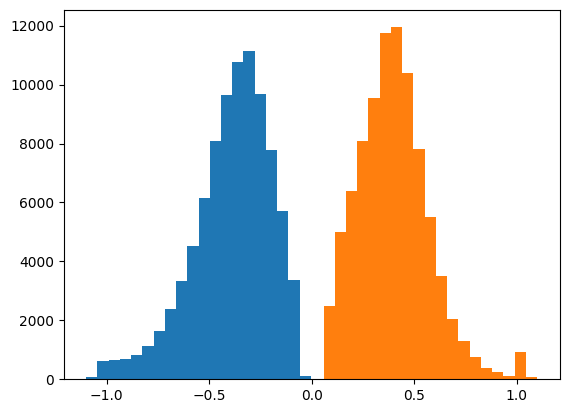

In [4]:
import numpy as np
import matplotlib.pyplot as plt

n_bins = 20

minmax_arr = np.array(minmax)
plt.hist(minmax_arr[:,0].clip(-1.1,1.1), bins=n_bins, label="Min")
plt.hist(minmax_arr[:,1].clip(-1.1,1.1), bins=n_bins, label="Max")

In [5]:
print("Num files:", len(minmax_arr))
print("Num w/ min<-1:", np.count_nonzero(minmax_arr[:,0]<-1))
print("Num w/ max>1:", np.count_nonzero(minmax_arr[:,1]>1))

Num files: 88328
Num w/ min<-1: 76
Num w/ max>1: 85


In [20]:
from TTS.bin.resample import resample_file
resample_file((r"C:\Users\iambl\GitHub\TTS\recipes\vctk\yourtts\VCTK\wav48_silence_trimmed\p225\p225_017_mic1.flac", 16000))

In [25]:
from tqdm import tqdm
from multiprocess import Pool
import glob
import os

def check_file(filename):
    import torchaudio
    x, sr = torchaudio.load(filename)
    if (x > 1).sum() + (x < -1).sum() != 0:
        return filename, True
    return filename, False

def check_files(input_dir, file_ext="wav", n_jobs=10):
    print("Checking the audio files...")
    audio_files = glob.glob(os.path.join(input_dir, f"**/*.{file_ext}"), recursive=True)
    print(f"Found {len(audio_files)} files...")
    failing_files = []
    with Pool(processes=n_jobs) as p:
        with tqdm(total=len(audio_files)) as pbar:
            for file, fails in p.imap_unordered(check_file, audio_files):
                if fails:
                    failing_files.append(file)
                pbar.update()

    print("Done !")
    return failing_files

In [26]:
PATH = "VCTK/"
NUM_RESAMPLE_THREADS = 10
failing_files = check_files(PATH, file_ext="flac", n_jobs=NUM_RESAMPLE_THREADS)
failing_files

Checking the audio files...
Found 88328 files...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 88328/88328 [00:29<00:00, 2972.32it/s]

Done !


['VCTK\\wav48_silence_trimmed\\p225\\p225_017_mic1.flac',
 'VCTK\\wav48_silence_trimmed\\p229\\p229_018_mic1.flac',
 'VCTK\\wav48_silence_trimmed\\p231\\p231_172_mic2.flac',
 'VCTK\\wav48_silence_trimmed\\p233\\p233_029_mic1.flac',
 'VCTK\\wav48_silence_trimmed\\p248\\p248_138_mic1.flac',
 'VCTK\\wav48_silence_trimmed\\p252\\p252_231_mic2.flac',
 'VCTK\\wav48_silence_trimmed\\p253\\p253_331_mic1.flac',
 'VCTK\\wav48_silence_trimmed\\p258\\p258_409_mic2.flac',
 'VCTK\\wav48_silence_trimmed\\p260\\p260_003_mic2.flac',
 'VCTK\\wav48_silence_trimmed\\p262\\p262_370_mic1.flac',
 'VCTK\\wav48_silence_trimmed\\p262\\p262_370_mic2.flac',
 'VCTK\\wav48_silence_trimmed\\p271\\p271_023_mic1.flac',
 'VCTK\\wav48_silence_trimmed\\p279\\p279_017_mic2.flac',
 'VCTK\\wav48_silence_trimmed\\p279\\p279_266_mic1.flac',
 'VCTK\\wav48_silence_trimmed\\p286\\p286_019_mic1.flac',
 'VCTK\\wav48_silence_trimmed\\p288\\p288_018_mic1.flac',
 'VCTK\\wav48_silence_trimmed\\p299\\p299_221_mic1.flac',
 'VCTK\\wav48_

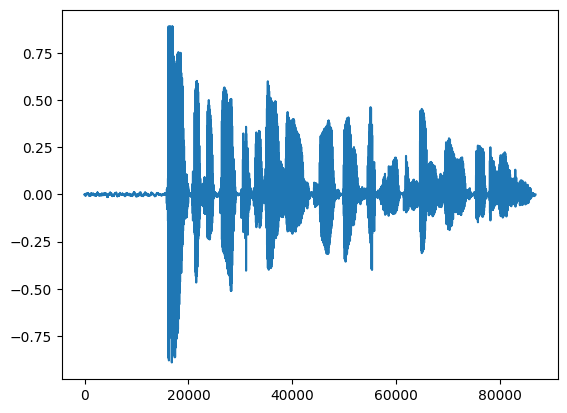

In [38]:
import torchaudio
import numpy as np
import matplotlib.pyplot as plt

x, sr = torchaudio.load(failing_files[1])
plt.plot(x[0])

In [36]:
import audacity

aud = audacity.AudacityScript()
audacity.quick_test(aud)

pipe-test.py, running on windows
Write to  "\\.\pipe\ToSrvPipe"
Read from "\\.\pipe\FromSrvPipe"
-- Both pipes exist.  Good.


OSError: [Errno 22] Invalid argument: '\\\\.\\pipe\\ToSrvPipe'

In [40]:
for file in failing_files:
    _, fails = check_file(file)
    if fails:
        print(file)